# [Intriguing properties of neural networks](http://arxiv.org/abs/1312.6199)

​This paper reports two counter-intuitive properties:

- It is the **space**, rather than the individual units, that contains the semantic information in the high layers of neural networks.
- We can cause the network to **misclassify an image** by applying **a certain hardly perceptible perturbation**, which is found by maximizing the network’s prediction error. In addition, the specific nature of these perturbations is not a random artifact of learning: the same perturbation can cause a different network, that was trained on a different subset of the dataset, to misclassify the same input.

​We term the so perturbed examples “**adversarial examples**”. These results suggest that the deep neural networks that are learned by backpropagation have nonintuitive characteristics and intrinsic blind spots, **whose structure is connected to the data distribution in a non-obvious way**.

## Framework

For the MNIST dataset, we used a simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_train = dset.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test = dset.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )
        
        self.layer_3 = nn.Sequential(
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
    
        return out_3, out_2, out_1

model=FC().to(device)

In [5]:
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=0.0001)

In [6]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model(X)
        cost=loss(pre,Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('Finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:0.54118
epoch:[1/10], iter:[200/600], loss:0.27552
epoch:[1/10], iter:[300/600], loss:0.22038
epoch:[1/10], iter:[400/600], loss:0.25307
epoch:[1/10], iter:[500/600], loss:0.16782
epoch:[1/10], iter:[600/600], loss:0.36493
epoch:[2/10], iter:[100/600], loss:0.19198
epoch:[2/10], iter:[200/600], loss:0.21138
epoch:[2/10], iter:[300/600], loss:0.14068
epoch:[2/10], iter:[400/600], loss:0.14433
epoch:[2/10], iter:[500/600], loss:0.22246
epoch:[2/10], iter:[600/600], loss:0.07278
epoch:[3/10], iter:[100/600], loss:0.21727
epoch:[3/10], iter:[200/600], loss:0.05917
epoch:[3/10], iter:[300/600], loss:0.15569
epoch:[3/10], iter:[400/600], loss:0.10661
epoch:[3/10], iter:[500/600], loss:0.04939
epoch:[3/10], iter:[600/600], loss:0.12613
epoch:[4/10], iter:[100/600], loss:0.08693
epoch:[4/10], iter:[200/600], loss:0.17265
epoch:[4/10], iter:[300/600], loss:0.06624
epoch:[4/10], iter:[400/600], loss:0.18787
epoch:[4/10], iter:[500/600], loss:0.10788
epoch:[4/10

In [7]:
model.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs,_,_ = model(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 97.549995 %


In [8]:
def imshow(img):
    image = img.cpu().clone().numpy()
    plt.figure(figsize=(10, 20))
    # image -> (channel, row, col)
    # plt.imshow(row,col,channel)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

## Units of $φ(x)$

Visual inspection of images $x′$, which satisfy (or are close to maximum attainable value):

$$
x′ = \arg \underset{x \in \mathcal{I}} {max} <φ(x),v>
$$


The experiment suggests that the natural basis is not better than a random basis for inspecting the properties of $φ(x)$. This puts into question the notion that neural networks disentangle variation factors across coordinates.

### in the natural basis direction

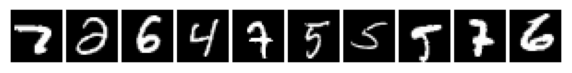

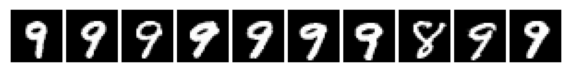

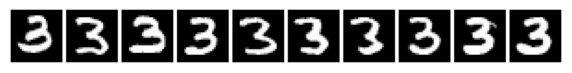

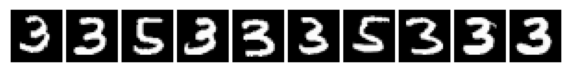

In [9]:
for i in range(4):
    unit = torch.eye(100)[i,:]

    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model(images)
        values=torch.mv(phi_x.cpu(),unit)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

### in a random basis

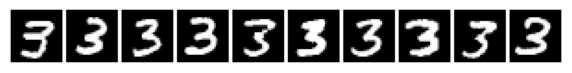

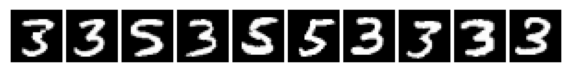

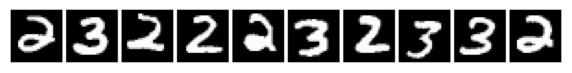

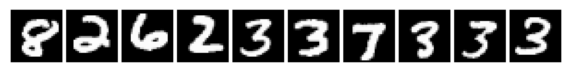

In [10]:
for i in range(4):
    direction= torch.rand(100)
    
    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model(images)
        values=torch.mv(phi_x.cpu(),direction)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

## Blind Spots in Neural Networks(“**adversarial examples**”)

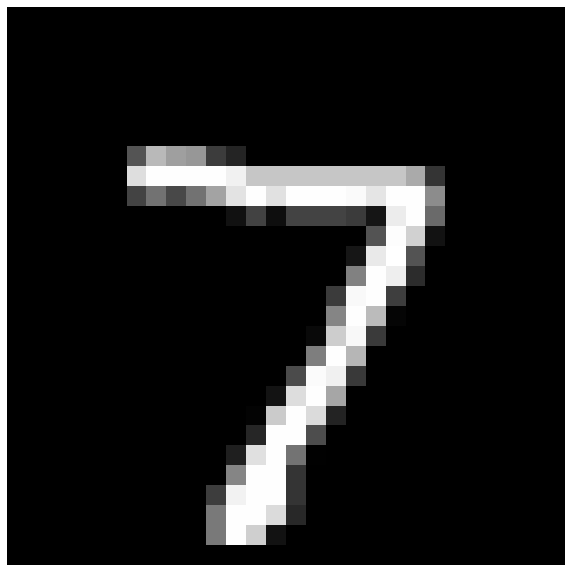

In [11]:
sample_img=mnist_test[0][0]
output,_,_=model(sample_img.to(device))
_,prediction=torch.max(output.data,1)
imshow(torchvision.utils.make_grid(sample_img, normalize=True))

num: 0, epoch: [45/1000], prediction: 0, loss_adv: 31.53344
Attack success! The number is  0


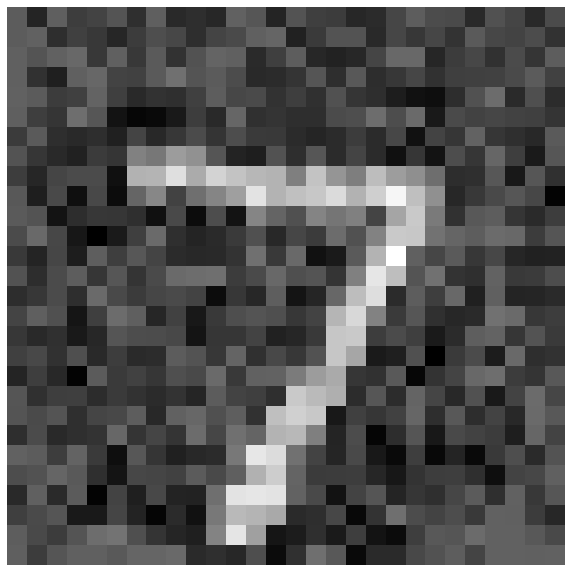

num: 1, epoch: [50/1000], prediction: 1, loss_adv: 14.13436
Attack success! The number is  1


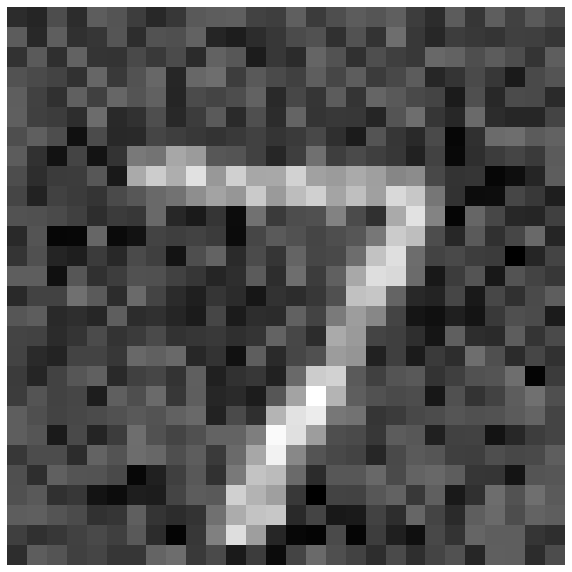

num: 2, epoch: [51/1000], prediction: 2, loss_adv: 13.60161
Attack success! The number is  2


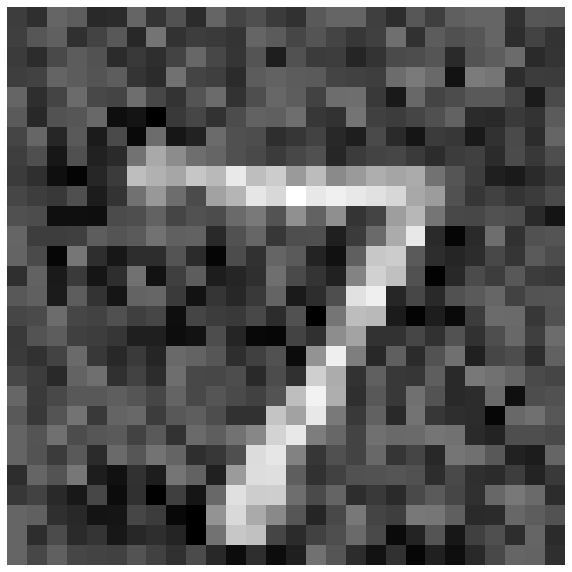

num: 3, epoch: [34/1000], prediction: 3, loss_adv: 23.84296
Attack success! The number is  3


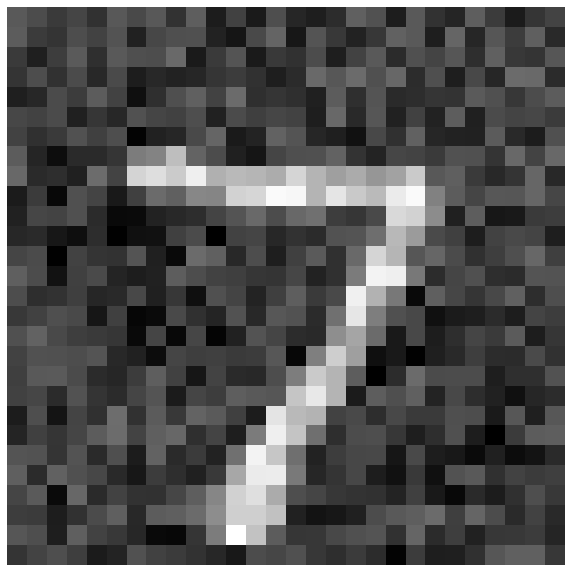

num: 4, epoch: [48/1000], prediction: 4, loss_adv: 46.32926
Attack success! The number is  4


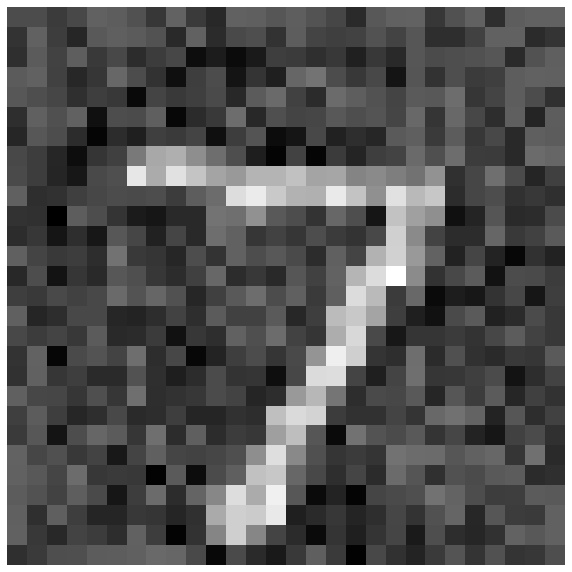

num: 5, epoch: [46/1000], prediction: 5, loss_adv: 173.76688
Attack success! The number is  5


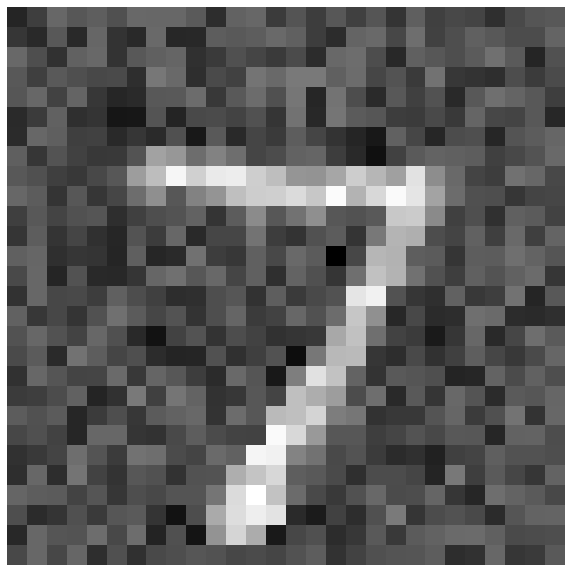

num: 6, epoch: [56/1000], prediction: 6, loss_adv: 18.69868
Attack success! The number is  6


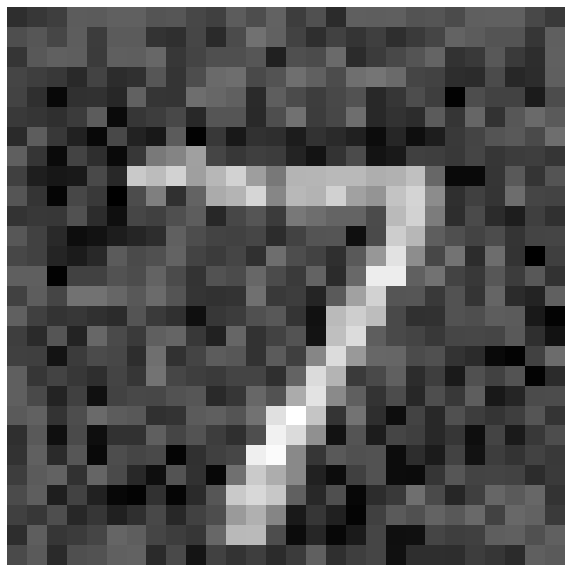

num: 7, epoch: [100/1000], prediction: 7, loss_adv: 14.61012
num: 7, epoch: [200/1000], prediction: 7, loss_adv: 0.15430
num: 7, epoch: [300/1000], prediction: 7, loss_adv: 0.01780
num: 7, epoch: [400/1000], prediction: 7, loss_adv: 0.01854
num: 7, epoch: [500/1000], prediction: 7, loss_adv: 0.01238
num: 7, epoch: [600/1000], prediction: 7, loss_adv: 0.01753
num: 7, epoch: [700/1000], prediction: 7, loss_adv: 0.01623
num: 7, epoch: [800/1000], prediction: 7, loss_adv: 0.01152
num: 7, epoch: [900/1000], prediction: 7, loss_adv: 0.01187
num: 7, epoch: [1000/1000], prediction: 7, loss_adv: 0.01089


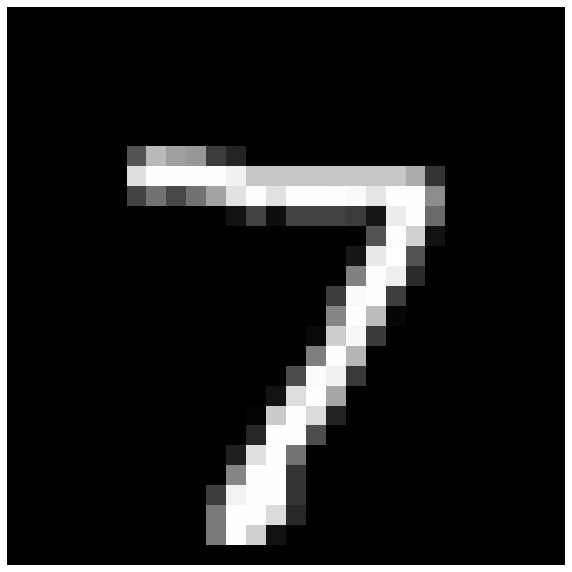

num: 8, epoch: [39/1000], prediction: 8, loss_adv: 43.09539
Attack success! The number is  8


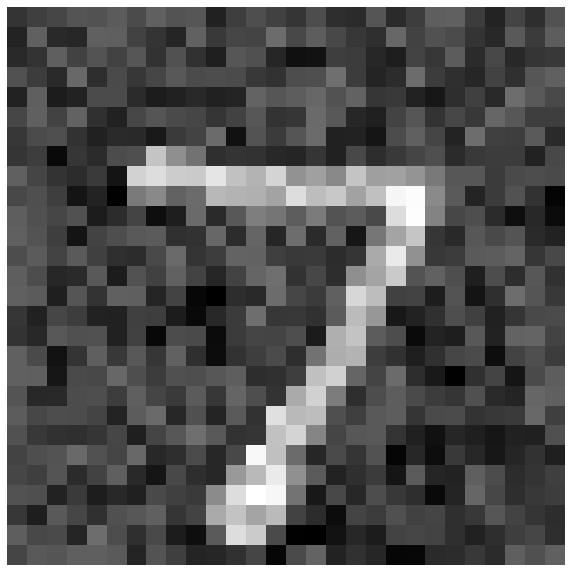

num: 9, epoch: [31/1000], prediction: 9, loss_adv: 18.04544
Attack success! The number is  9


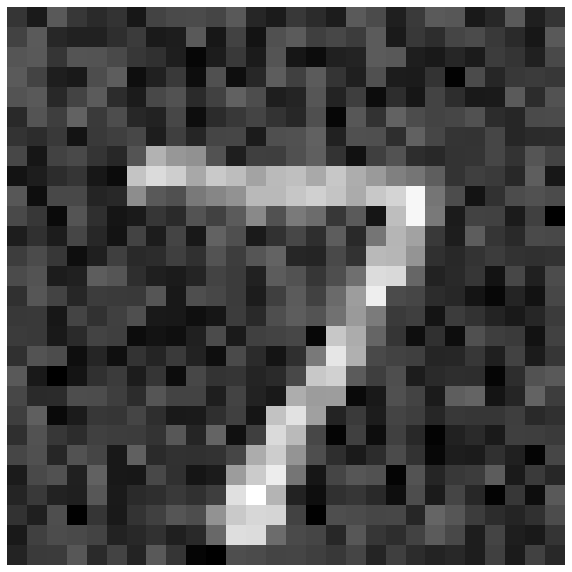

In [12]:
right=sample_img-torch.zeros_like(sample_img)
left=sample_img-torch.ones_like(sample_img)

m=100
for num in range(10):

    r = torch.zeros_like(sample_img).cuda()
    for i in range(r.shape[1]):
        for j in range(r.shape[2]):
            r[0,i,j]=np.random.uniform(right[0,i,j],left[0,i,j])
    r.requires_grad = True
    
    c = torch.rand(1).cuda()
    c = 1 / (c + 1e-10)
    c.requires_grad = True

    # optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
    optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
    for i in range(1000):

        X = sample_img.cuda() + r.cuda()
        Y = torch.tensor([num]).cuda()

        output,_,_ = model(X)
        _,prediction = torch.max(output.data,1)

        loss_adv= c.abs() * torch.norm(r, p=2).cuda() + loss(output,Y)

        def closure():
            return loss_adv
        
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step(closure=closure)


        if (i+1) % 100 == 0:
            print('num: %d, epoch: [%d/%d], prediction: %d, loss_adv: %.5f' % (num, i+1, 1000, prediction.item(), loss_adv.item()))
            
        
        if (i+1) == 1000:
            imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True))

        if prediction.item() != 7 and prediction.item() == num:
            print('num: %d, epoch: [%d/%d], prediction: %d, loss_adv: %.5f' % (num, i+1, 1000, prediction.item(), loss_adv.item()))
            print('Attack success! The number is ',prediction.item())
            imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True))
            break
    
